# 2. Scaled Dot-Product Attention

**The core innovation that makes transformers powerful**

**The core innovation of transformers:** Attention is the mechanism that allows each word to "look at" and gather information from all other words in the sentence.

**A concrete example:** Consider "The animal didn't cross the street because it was too tired." What does "it" refer to? A human knows "it" refers to "the animal" (not "the street"). Attention allows the model to learn this—when processing "it", the model can attend strongly to "animal".

## How Attention Works

The mechanism uses three components for each token:

- **Query (Q):** "What am I looking for?" - what the current token wants to know
- **Key (K):** "What do I contain?" - what information each token offers
- **Value (V):** "What information do I have?" - the actual content passed along

**The formula:**

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

The division by $\sqrt{d_k}$ prevents very large dot products in high dimensions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ScaledDotProductAttention(nn.Module):
    """Compute scaled dot-product attention."""
    
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query: (batch, seq_len, d_k)
            key: (batch, seq_len, d_k)
            value: (batch, seq_len, d_v)
            mask: optional mask for causal attention
        
        Returns:
            output: (batch, seq_len, d_v)
            attention_weights: (batch, seq_len, seq_len)
        """
        d_k = query.size(-1)
        
        # Compute attention scores: Q·K^T / √d_k
        scores = torch.matmul(query, key.transpose(-2, -1))
        scores = scores / math.sqrt(d_k)
        
        # Apply causal mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 1, float('-inf'))
        
        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply weights to values
        output = torch.matmul(attention_weights, value)
        
        return output, attention_weights

In [2]:
# Example: Self-attention on a sequence
batch_size = 2
seq_len = 5
d_k = 64

# Random Q, K, V (in practice, these come from linear projections)
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

attention = ScaledDotProductAttention()
output, weights = attention(Q, K, V)

print(f"Query shape: {Q.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {weights.shape}")
print(f"\nAttention weights for first sequence, first position:")
print(f"  {weights[0, 0].detach().numpy().round(3)}")
print(f"  Sum: {weights[0, 0].sum().item():.4f} (should be 1.0)")

Query shape: torch.Size([2, 5, 64])
Output shape: torch.Size([2, 5, 64])
Attention weights shape: torch.Size([2, 5, 5])

Attention weights for first sequence, first position:
  [0.085 0.288 0.076 0.055 0.495]
  Sum: 1.0000 (should be 1.0)


## Causal Masking

In decoder-only transformers (like GPT), we add a mask to prevent tokens from attending to future positions. This is essential for autoregressive generation—when predicting the next word, the model shouldn't "cheat" by looking ahead!

In [3]:
def create_causal_mask(seq_len):
    """Create a causal mask that prevents attending to future positions."""
    # Upper triangular matrix of 1s (future positions)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask

# Visualize the mask
mask = create_causal_mask(5)
print("Causal mask (1 = masked/can't attend):")
print(mask.int())
print("\nInterpretation:")
print("- Position 0 can only see position 0")
print("- Position 1 can see positions 0, 1")
print("- Position 4 can see all positions 0-4")

Causal mask (1 = masked/can't attend):
tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

Interpretation:
- Position 0 can only see position 0
- Position 1 can see positions 0, 1
- Position 4 can see all positions 0-4


In [4]:
# Apply causal mask
output_masked, weights_masked = attention(Q, K, V, mask=mask)

print("Attention weights WITH causal mask:")
print("\nPosition 0 (can only see itself):")
print(f"  {weights_masked[0, 0].detach().numpy().round(3)}")
print("\nPosition 2 (can see positions 0, 1, 2):")
print(f"  {weights_masked[0, 2].detach().numpy().round(3)}")
print("\nPosition 4 (can see all):")
print(f"  {weights_masked[0, 4].detach().numpy().round(3)}")

Attention weights WITH causal mask:

Position 0 (can only see itself):
  [1. 0. 0. 0. 0.]

Position 2 (can see positions 0, 1, 2):
  [0.443 0.386 0.171 0.    0.   ]

Position 4 (can see all):
  [0.095 0.595 0.201 0.07  0.04 ]


## Visualizing Attention Patterns

Attention weights show us what each position is "looking at". This is useful for interpretability.

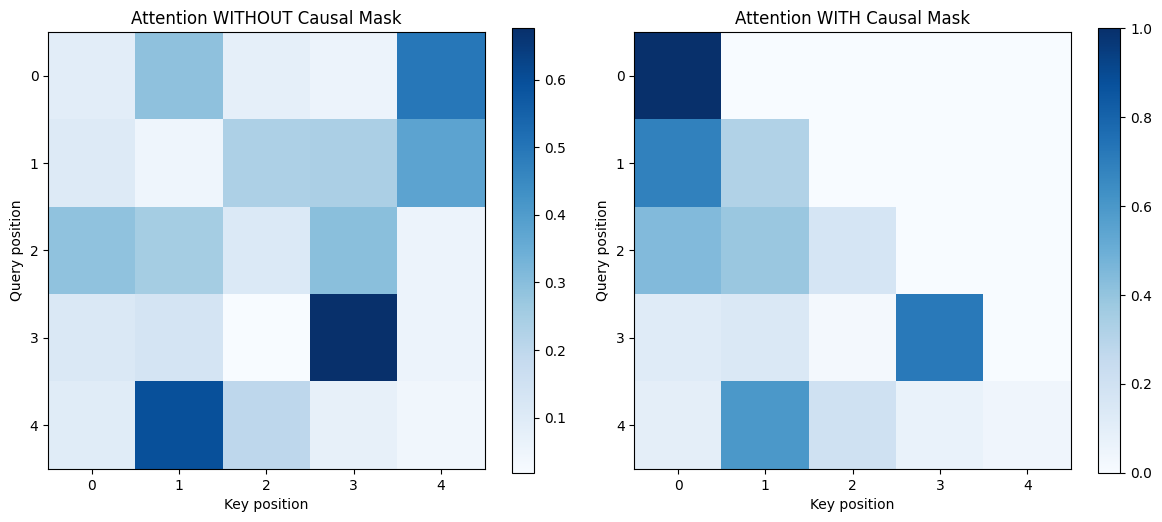

In [5]:
import matplotlib.pyplot as plt

# Create a sample attention pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Without mask
ax = axes[0]
im = ax.imshow(weights[0].detach().numpy(), cmap='Blues')
ax.set_title('Attention WITHOUT Causal Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

# With mask
ax = axes[1]
im = ax.imshow(weights_masked[0].detach().numpy(), cmap='Blues')
ax.set_title('Attention WITH Causal Mask')
ax.set_xlabel('Key position')
ax.set_ylabel('Query position')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## What We Learned

1. **Attention computes compatibility** between queries and keys using dot products
2. **Softmax converts scores** to a probability distribution
3. **The output is a weighted sum** of values based on attention weights
4. **Causal masking** prevents looking at future positions for autoregressive models

## Next: Multi-Head Attention

Running multiple attention heads in parallel allows the model to capture different types of relationships simultaneously.